In [355]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
import surprise
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from scipy import stats
from surprise import NMF
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from collections import defaultdict
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
%matplotlib inline

In [276]:
# load the data set for full ratings
ratings = pd.read_csv('/Users/weixiyao/desktop/PERS_HW2/ml-latest/ratings.csv', 
                      usecols=['userId', 'movieId', 'rating'],
                      dtype={'user|Id':'int32', 'movieId':'int32', 'rating':'float128'},
                      sep=',')

print("number of distinct participated users: ", ratings['userId'].nunique())
print("number of distinct rated movies: ", ratings['movieId'].nunique())

number of distinct participated users:  283228
number of distinct rated movies:  53889


**Create a subset of dataset, save it for performance measurement**

In [277]:
ratings_full = sample_dateset_by_percentile(ratings, 25000, 1000)
print("number of distinct participated users (full): ", ratings_full['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_full['movieId'].nunique())

number of distinct participated users (full):  24511
number of distinct rated movies (full):  1000


In [278]:
reader = Reader()
data_full = Dataset.load_from_df(ratings_full[['userId', 
                                               'movieId', 
                                               'rating']], 
                                 reader=reader)

**Create a subset of dataset, save it for development**

In [279]:
ratings_sub = sample_dateset_by_percentile(ratings_full, 1500, 200)
print("number of distinct participated users (subset): ", ratings_sub['userId'].nunique())
print("number of distinct rated movies (subset): ", ratings_sub['movieId'].nunique())

number of distinct participated users (subset):  1487
number of distinct rated movies (subset):  200


In [280]:
reader = Reader()
data_sub = Dataset.load_from_df(ratings_sub[['userId', 
                                             'movieId', 
                                             'rating']], 
                                reader=reader)

## Part 2: Two models building

### Part 2.1: Item-based neighborhood method

In [461]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)

In [282]:
item_model = KNNWithMeans(k=4, sim_options={'name': 'pearson', 
                                            'user_based': False, 
                                            'verbose' : False})

In [284]:
item_model.fit(trainvalset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [285]:
uid = str(699)
iid = str(296)
item_model_pred = item_model.predict(uid, 
                                     iid, 
                                     verbose=False)
print("Prediction for rating: ", pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.49   {'was_impossible': False}


### Part 2.2: Matrix Factorization

In [286]:
NMF_model = NMF(n_factors=20, 
                n_epochs=10, 
                biased=True)

In [287]:
NMF_model.fit(trainvalset);

In [288]:
uid = str(699)
iid = str(296)
pred = NMF_model.predict(uid, 
                         iid,
                         verbose=False)
print("Prediction for rating: ", pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.50   {'was_impossible': False}


## Part 3: Model evaluation

### Part 3.1.1: CV setup for item-based neighborhood method

For this task, we will use MSE(Mean Squared Error) as the primary accuracy metric and MAE(Mean Absolute Error) as the secondary accuracy metric.

In [289]:
# Run 5-fold cross-validation and print results
result = cross_validate(item_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9524  0.9478  0.9564  0.9531  0.9501  0.9520  0.0029  
MAE (testset)     0.7190  0.7164  0.7209  0.7184  0.7188  0.7187  0.0014  
RMSE (trainset)   0.4187  0.4174  0.4191  0.4186  0.4186  0.4185  0.0006  
MAE (trainset)    0.3129  0.3121  0.3133  0.3129  0.3129  0.3128  0.0004  
Fit time          0.71    0.83    0.92    0.91    0.84    0.84    0.08    
Test time         1.90    2.36    2.28    2.00    2.08    2.12    0.17    


### Part 3.1.2: coverage

In [553]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [554]:
user_list_train = set(trainvalset.all_users())
user_list_test = set([item[0] for item in testset])

item_list_train = set(trainvalset.all_items())
item_list_test = set([item[1] for item in testset])

In [555]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)
trainvalset_testfy = trainvalset.build_anti_testset()

In [556]:
predictions_train = item_model.test(trainvalset_testfy)
predictions_test = item_model.test(testset)

In [557]:
top_n_train = get_top_n(predictions_train, n=2)
top_n_test = get_top_n(predictions_test, n=2)

In [558]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])

In [559]:
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [560]:
len(recommendation_train_list)

84

In [561]:
print('coverage on train set', '{:f}'.format(len(recommendation_train_list)/len(item_list_train)))

coverage on train set 0.420000


In [562]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])

In [563]:
recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [564]:
len(recommendation_test_list)

139

In [565]:
print('coverage on test set', '{:f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on test set 0.776536


### Part 3.1: CV setup for Matrix Factorization

In [148]:
# Run 5-fold cross-validation and print results
result = cross_validate(NMF_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4618  1.4140  1.2466  1.9443  1.4466  1.5027  0.2338  
MAE (testset)     1.1307  1.0972  0.9441  1.5879  1.1256  1.1771  0.2164  
RMSE (trainset)   1.4591  1.3982  1.2267  1.9401  1.4306  1.4909  0.2387  
MAE (trainset)    1.1242  1.0791  0.9263  1.5816  1.1040  1.1630  0.2206  
Fit time          4.43    4.32    4.53    4.64    4.22    4.43    0.15    
Test time         0.60    0.44    0.65    0.64    0.45    0.56    0.09    


### Part 3.2.2: coverage

In [566]:
predictions_train = NMF_model.test(trainvalset_testfy)
predictions_test = NMF_model.test(testset)

In [567]:
top_n_train = get_top_n(predictions_train, n=2)
top_n_test = get_top_n(predictions_test, n=2)

In [568]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])

In [569]:
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [570]:
len(recommendation_train_list)

30

In [571]:
print('coverage on train set', '{:f}'.format(len(recommendation_train_list)/len(item_list_train)))

coverage on train set 0.150000


In [572]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])

In [573]:
recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [574]:
len(recommendation_test_list)

144

In [575]:
print('coverage on test set', '{:f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on test set 0.804469


## Part 4: GridSearch

### Part 4.1: GS setup for item-based neighborhood method

In [432]:
param_grid = {'k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [444]:
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [434]:
gs.fit(data_sub)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [435]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [438]:
n_k = results_df['param_k']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [439]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 1.002963
BEST MAE 0.775107


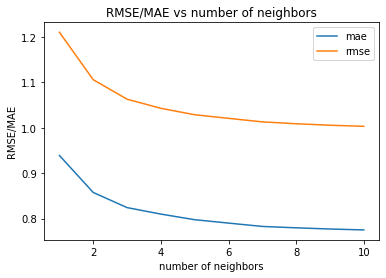

In [442]:
fig, ax = plt.subplots()
ax.plot(n_k, mae_results, label='mae');
ax.plot(n_k, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of neighbors')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of neighbors increases, both of the accuracy measures decrease. This makes sense because as the model considers more items(neighbors) while making predictions, the model becomes more capable of making more accurate predictions.

### Part 4.2: GS setup for Matrix Factorization

In [446]:
param_grid = {'n_factors': [10, 20, 30, 40, 50, 60, 70]}

In [447]:
gs = GridSearchCV(NMF, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [448]:
gs.fit(data_sub)

In [449]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [450]:
n_factors = results_df['param_n_factors']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [451]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 1.015863
BEST MAE 0.775138


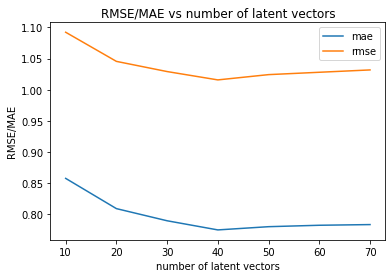

In [452]:
fig, ax = plt.subplots()
ax.plot(n_factors, mae_results, label='mae');
ax.plot(n_factors, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of latent vectors')
ax.set_xlabel('number of latent vectors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of latent vectors increases, both of the accuracy measures decrease. This makes sense because the matrix factorization algorithm re-constructs the true matrix more accurately with higher latent vector size.

## Part 5: Other design

There are two key observations arise from the above section:

1. Models with higher complexity usually perform better.
    - According to the grid-search results, the "accuracy" of the models increase as the number of latent vectors/number of neightbos increase. Therefore, if we want to further increase the accuracy of the baseline models built previously, we should definitely construct models with reasonably high complexity.


2. The test set's coverage of the more "accurate" model is lower.
    - xxx
 